<a href="https://colab.research.google.com/github/DJCordhose/ml-resources/blob/main/notebooks/cv/faces-odsc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Recognition with OpenCV and TensorFlow

1. Make sure you are connected to Wifi
1. Open this colab notebook: http://bit.ly/odsc-2022-cv
1. Make sure you are logged in with your Google account (if you do not have one, you can just create one today)
1. Make a copy of that notebook in your Drive (this is the only notebook you will work in today)

### ODSC West, San Francisco, November 2022

https://odsc.com/speakers/image-recognition-with-opencv-and-tensorflow/

Oliver Zeigermann, OPEN KNOWLEDGE
oliver.zeigermann@openknowledge.de
https://twitter.com/DJCordhose


# Getting and preprocessing faces data

* https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data
* https://www.kaggle.com/datasets/msambare/fer2013
* https://blog.devgenius.io/facial-expression-recognition-with-tensorflow-90f6174163c3
  * https://github.com/joaopdss/FacialExpressionRecognition/blob/main/Facial_expression_recognition%20.ipynb

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 8)
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 20

In [2]:
import numpy as np
np.__version__

'1.21.6'

In [3]:
import pandas as pd
pd.__version__

'1.3.5'

In [4]:
!wget -c https://github.com/DJCordhose/ml-resources/raw/main/data/tmp/fer2013.tar.gz

--2022-10-29 18:13:34--  https://github.com/DJCordhose/ml-resources/raw/main/data/tmp/fer2013.tar.gz
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/DJCordhose/ml-resources/main/data/tmp/fer2013.tar.gz [following]
--2022-10-29 18:13:34--  https://media.githubusercontent.com/media/DJCordhose/ml-resources/main/data/tmp/fer2013.tar.gz
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 416 Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [5]:
!tar -xzvf fer2013.tar.gz

fer2013/fer2013.csv
fer2013/README
fer2013/fer2013.bib
fer2013/


In [6]:
FER2013_CSV_PATH = "./fer2013/fer2013.csv"

In [7]:
df = pd.read_csv(FER2013_CSV_PATH)
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [8]:
label_names = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

In [9]:
df["emotion"].value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [10]:
def plot_data(data, classes):
  
  values = data["emotion"].value_counts().sort_index(ascending=True)

  plt.bar(x=classes, height=values, edgecolor='black')

  plt.xlabel("Emotions")
  plt.ylabel("Amount")
  plt.title("Amount of emotions")
  plt.show();

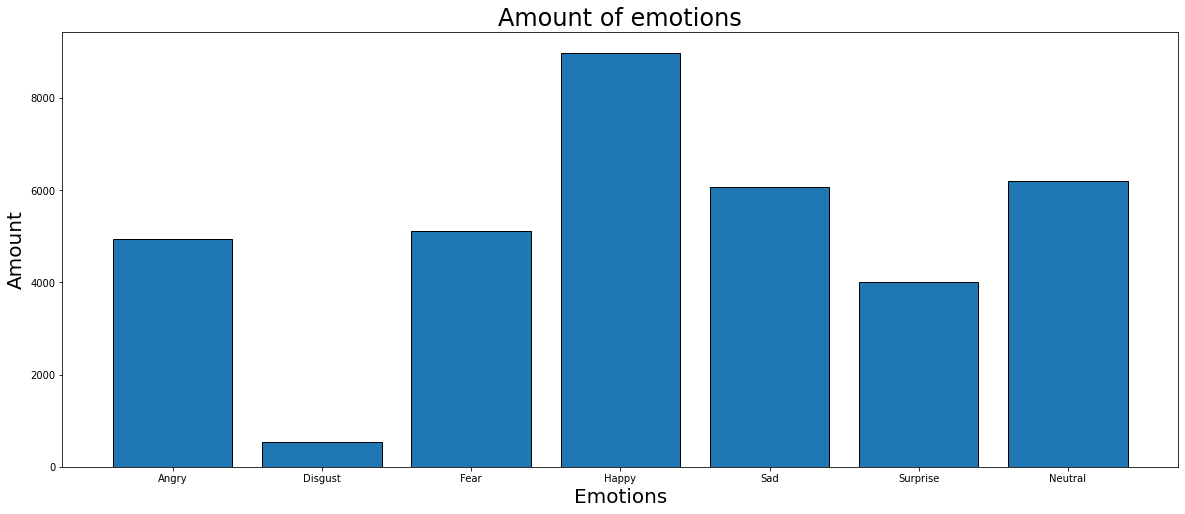

In [11]:
plot_data(df, label_names)

taking advice from 

https://github.com/joaopdss/FacialExpressionRecognition/blob/main/Facial_expression_recognition%20.ipynb

we leave out fear and disgust because they are hard to produce, plus disgust has few samples only

In [12]:
filtered_df = df[df["emotion"].isin([0, 3, 4, 5, 6, 7])] 

In [13]:
# now some labels just don't have a samples, we shift all lables to the left

filtered_df["emotion"].value_counts()

3    8989
6    6198
4    6077
0    4953
5    4002
Name: emotion, dtype: int64

In [14]:
filtered_label_names = ["Angry", "Happy", "Sad", "Surprise", "Neutral"]

In [15]:
# pandas again makes this impossible to get right without stack overflow
# this does work even though we can an error
filtered_df.loc[filtered_df["emotion"] == 3, "emotion"] = 1
filtered_df.loc[filtered_df["emotion"] == 4, "emotion"] = 2
filtered_df.loc[filtered_df["emotion"] == 5, "emotion"] = 3
filtered_df.loc[filtered_df["emotion"] == 6, "emotion"] = 4

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [16]:
filtered_df["emotion"].value_counts()

1    8989
4    6198
2    6077
0    4953
3    4002
Name: emotion, dtype: int64

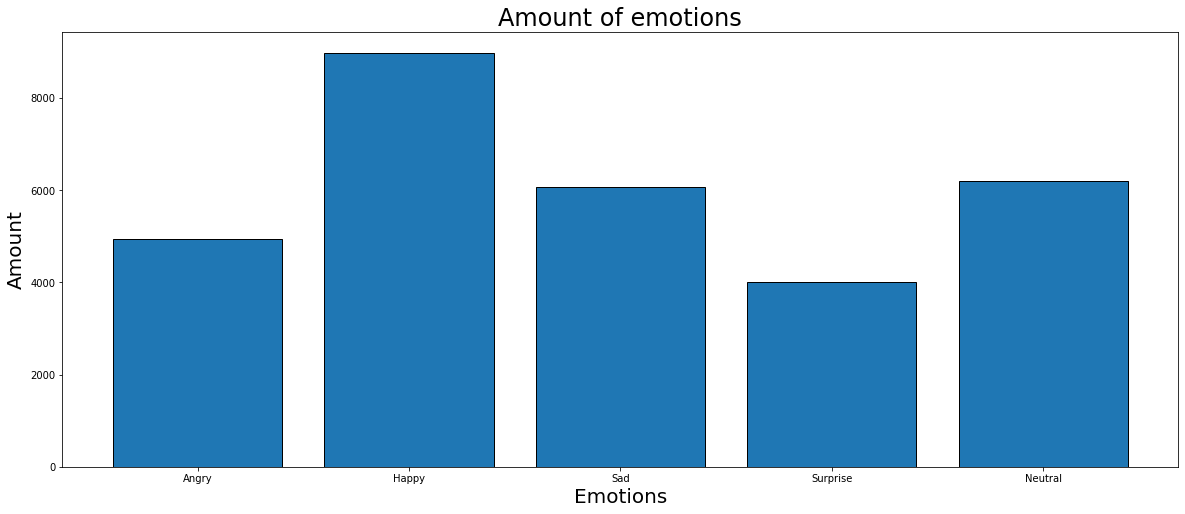

In [17]:
plot_data(filtered_df, filtered_label_names)

In [18]:
df = filtered_df

In [19]:
pixels = df["pixels"]
len(pixels)

30219

In [20]:
resolution = (48, 48)
def image_from_pixels(pixels):
    image = np.reshape(np.array(pixels.split(), 'float64'), resolution)
    return image

In [21]:
%%time

images = np.array([image_from_pixels(p) for p in pixels])
images.shape

CPU times: user 8.41 s, sys: 529 ms, total: 8.94 s
Wall time: 8.91 s


(30219, 48, 48)

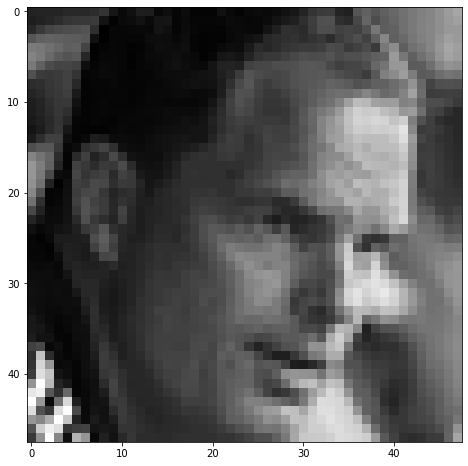

In [22]:
plt.imshow(images[100], cmap='gray');

In [23]:
labels = df["emotion"].values

In [24]:
labels.shape

(30219,)

In [25]:
def plot_gallery(X, y, label_names, size=15):

    population = X.shape[0]
    if size and size < population:
        samples = np.random.choice(population, size=size, replace=False)
    else:
        # just all
        samples = np.arange(0, population)

    for idx, i in enumerate(samples):
        ax = plt.subplot(3, 5, idx + 1)
        image = X[i]
        plt.imshow(image, cmap='gray')
        y_true = y[i]
        plt.title(label_names[y_true])
        plt.axis("off")

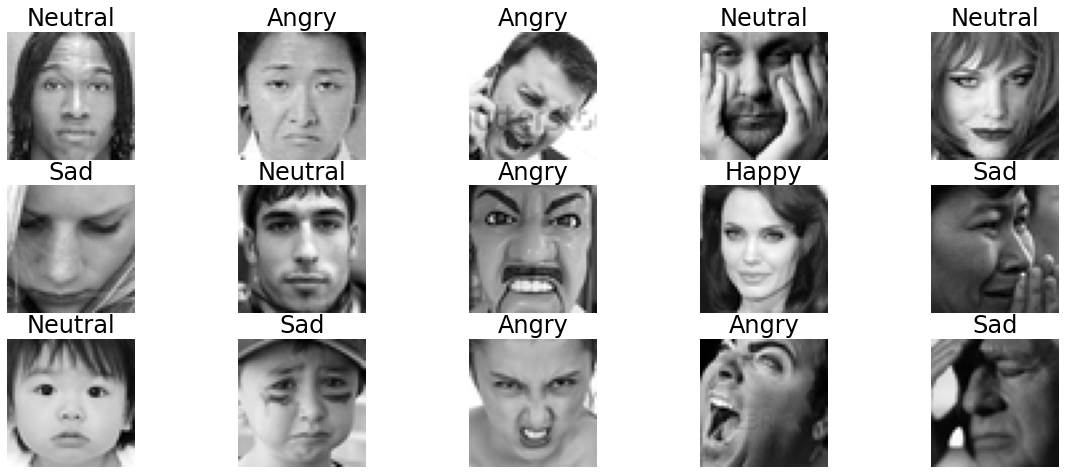

In [26]:
plot_gallery(images, labels, filtered_label_names)

## Preparing Training

In [27]:
images.shape, images.dtype

((30219, 48, 48), dtype('float64'))

In [28]:
# images encoded as 0..255 bit maps
# neural networks can deal with bytes, but like floats close to 0 better
images.max(), images.min()

(255.0, 0.0)

In [29]:
# sometimes numpy is just great: broadcast
images_normlized = images / 255.0

# we also need to expand images, as the prebuild networks expect that
images_normlized = np.expand_dims(images_normlized, axis=-1)

In [30]:
images_normlized.shape, images_normlized.dtype, images_normlized.max(), images_normlized.min()

((30219, 48, 48, 1), dtype('float64'), 1.0, 0.0)

In [31]:
# our default tools are still flexible enough to work with this
# (or not as the version of matplotlib running on colab)

# plot_gallery(images_normlized, y, label_names)

In [32]:
input_shape=(48, 48, 1)

In [33]:
np.unique(labels)

array([0, 1, 2, 3, 4])

In [34]:
num_classes = labels.max() + 1
num_classes

5

In [35]:
X = images_normlized
y = labels

## What kind of model should we use?

* Coming up with a decent CNN architecture is a research topic
* Using a prebuilt architecture often is the best choice
  * https://keras.io/api/applications/
  * having a lot of good training data, can make additional regularization unnecessary
  * it can be done, though, but not trivially: https://sthalles.github.io/keras-regularizer/
* however, accuracy is not the only metric we are concerned about
  * we also need this to be portable to run in the browser in the first place, plus
  * we need this to react in near real time to be useable
  * training any default architecture on CPU is simply not feasible
  * do we have a GPU availble for training 
  * which one, how powerful?
  * even on GPU this can take quite some time

In [36]:
import tensorflow as tf
tf.__version__

'2.9.2'

In [37]:
!nvidia-smi

Sat Oct 29 18:13:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0    44W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [38]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Custom Model

In [39]:
from tensorflow.keras.layers import InputLayer, Dense, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Flatten

dropout = 0.5

model = tf.keras.Sequential(name='custom_vgg')

model.add(InputLayer(input_shape=input_shape, name='input'))

model.add(Conv2D(filters=32, kernel_size=3, activation='relu')) 
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Dense(num_classes, activation='softmax'))

### Standard Architecture

In [40]:
use_custom_model = True
# use_custom_model = False

In [41]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

if not use_custom_model:
  # model = ResNet50(weights='imagenet')
  model = ResNet50(weights=None, input_shape=input_shape, classes=num_classes)

In [42]:
model.summary()

Model: "custom_vgg"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 23, 23, 32)       128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 23, 23, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 64)       0

In [43]:
# https://github.com/AndreasMadsen/python-lrcurve
import sys

if 'google.colab' in sys.modules:
  !pip install -q lrcurve

In [44]:
# we play be our own rules, we do our own split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=21, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((27197, 48, 48, 1), (3022, 48, 48, 1), (27197,), (3022,))

### Training

In [45]:
if use_custom_model:
  optimizer='adam'
else:  
  # optimizer='adam'
  optimizer='sgd'
optimizer  

'adam'

In [46]:
model.compile(loss='sparse_categorical_crossentropy',
             optimizer=optimizer,
             metrics=['accuracy'])

In [47]:
if use_custom_model:
  patience = 5
else:  
  patience=10

In [48]:
# ReduceLROnPlateau inspirated by https://github.com/joaopdss/FacialExpressionRecognition/blob/main/Facial_expression_recognition%20.ipynb

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
reduce_lr = ReduceLROnPlateau()
early_stopping = tf.keras.callbacks.EarlyStopping(patience=patience)

In [49]:
%%time

from lrcurve import KerasLearningCurve

if use_custom_model:
  BATCH_SIZE = 50
else:
  # larger batch size might lead to better regularization for resent
  # (might speed up learning on a good GPU)
  BATCH_SIZE = 50

# Resnet50 75 epochs
# - 30 min on T4
# - 18 min on A100
# - < 15 min on V100

EPOCHS = 75
# should be enough for resnet
# EPOCHS = 50

history = model.fit(X_train, y_train, 
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    shuffle=True,
                    validation_data=(X_test, y_test),
                    # validation_split=0.1,
                    callbacks=[reduce_lr, early_stopping, KerasLearningCurve()],
                    verbose=0
                    )

CPU times: user 1min 46s, sys: 11.8 s, total: 1min 58s
Wall time: 1min 20s


## Evaluating results

In [50]:
train_loss, train_accuracy = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE, verbose=0)
train_loss, train_accuracy

(0.9839217066764832, 0.6146633625030518)

In [51]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=0)
test_loss, test_accuracy

(1.0458273887634277, 0.6015883684158325)

In [52]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_cm(model, X, y, file_name=None, label_names=label_names):
    y_pred = model.predict(X).argmax(axis=1)
    cm = confusion_matrix(y, y_pred)
    figure = plt.figure(figsize=(10, 10))

    sns.heatmap(cm, annot=True, xticklabels=label_names, yticklabels=label_names, cmap='Blues', fmt='d')
    if file_name:
        plt.savefig('outputs/%s.png' % file_name)

In [53]:
def plot_accuracy(history, file_name=None):
    plt.figure()
    plt.xlabel('epochs')
    plt.ylabel('accuracy')

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.legend(['Accuracy', 'Validation Accuracy']);
    if file_name:
        plt.savefig('outputs/%s.png' % file_name)

In [54]:
def plot_loss(history, file_name=None):
    plt.figure()

    plt.xlabel('epochs')
    plt.ylabel('loss')

    plt.yscale('log')

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.legend(['Loss', 'Validation Loss']);
    if file_name:
        plt.savefig('outputs/%s.png' % file_name)

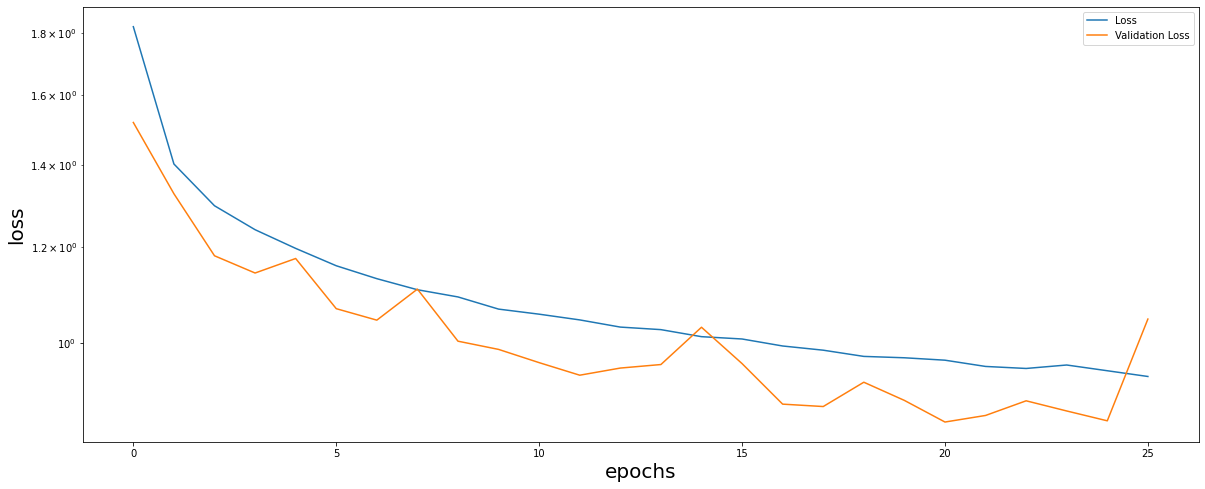

In [55]:
plot_loss(history)

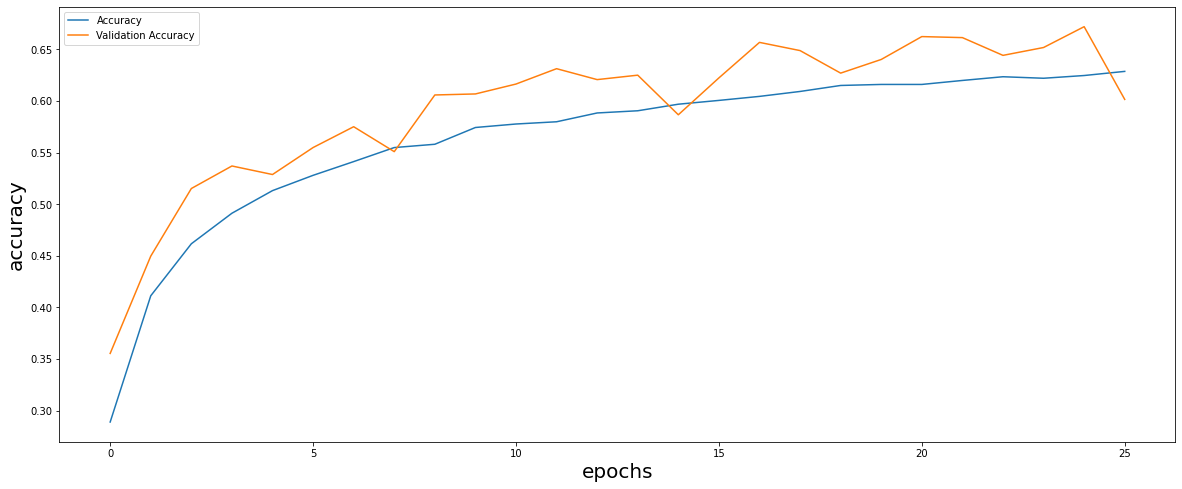

In [56]:
plot_accuracy(history)

850/850 [==============================] - 2s 2ms/step


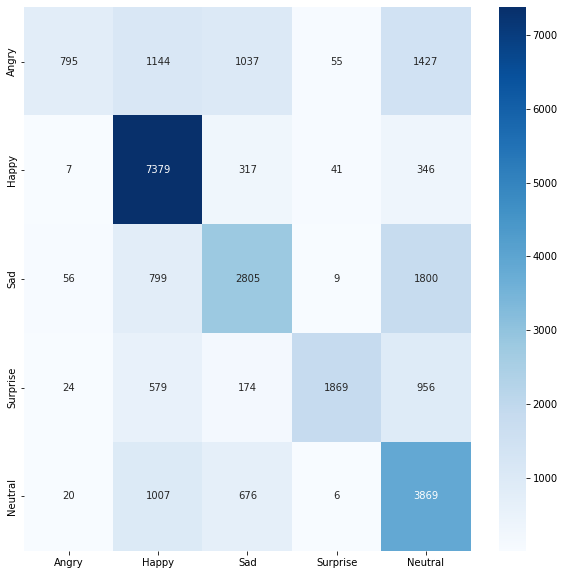

In [57]:
plot_cm(model, X_train, y_train, label_names=filtered_label_names)

95/95 [==============================] - 0s 3ms/step


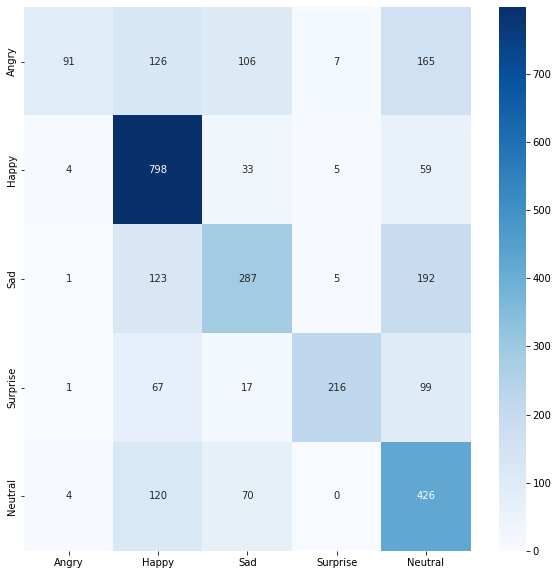

In [58]:
plot_cm(model, X_test, y_test, label_names=filtered_label_names)

## Saving model

In [59]:
if use_custom_model:
  model_name = 'simple-vgg.h5'
else:
  model_name = 'resent50.h5'
model.save(model_name)

In [60]:
!ls -l

total 1166700
drwxr-xr-x 7 root   root      4096 Oct 29 17:32 emotions
-rw-r--r-- 1 root   root  11744607 Oct 29 17:32 emotions.zip
-rw-r--r-- 1 root   root  11744607 Oct 29 17:41 emotions.zip.1
-rw-r--r-- 1 root   root  11744607 Oct 29 17:55 emotions.zip.2
drwxr-x--- 2 204241 5762      4096 Jul 10  2013 fer2013
-rw-r--r-- 1 root   root  96433867 Oct 29 18:05 fer2013.tar.gz
-rw-r--r-- 1 root   root  96433867 Oct 29 17:39 fer2013.tar.gz.1
-rw-r--r-- 1 root   root  96433867 Oct 29 17:53 fer2013.tar.gz.2
-rw-r--r-- 1 root   root 283704376 Oct 29 17:32 resent50.h5
-rw-r--r-- 1 root   root 283704376 Oct 29 17:42 resent50.h5.1
-rw-r--r-- 1 root   root 283704376 Oct 29 17:55 resent50.h5.2
drwxr-xr-x 1 root   root      4096 Oct 27 13:28 sample_data
-rw-r--r-- 1 root   root   4754784 Oct 29 18:15 simple-vgg.h5
-rw-r--r-- 1 root   root   4754784 Oct 29 17:32 simple-vgg.h5.1
-rw-r--r-- 1 root   root   4754784 Oct 29 17:42 simple-vgg.h5.2
-rw-r--r-- 1 root   root   4754784 Oct 29 17:55 simple-vgg.

## Challenge of our model

* Data for training comes from completely different source than for prediction
* Not uncommon
* Typically the case when having to rely on general / public dataset
* Often means test score is well below validation score
* Might need an extra round of training with small set of data from prediction source


In [61]:
!wget -c https://github.com/DJCordhose/ml-resources/raw/main/data/emotions.zip

--2022-10-29 18:15:27--  https://github.com/DJCordhose/ml-resources/raw/main/data/emotions.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/DJCordhose/ml-resources/main/data/emotions.zip [following]
--2022-10-29 18:15:27--  https://media.githubusercontent.com/media/DJCordhose/ml-resources/main/data/emotions.zip
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 416 Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [62]:
!unzip -o emotions.zip

Archive:  emotions.zip
  inflating: emotions/angry/leonie-angry.jpg  
  inflating: emotions/angry/olli-angry.jpg  
  inflating: emotions/angry/tim-angry.jpg  
  inflating: emotions/happy/leonie-happy.jpg  
  inflating: emotions/happy/olli-happy.jpg  
  inflating: emotions/happy/tim-happy.jpg  
  inflating: emotions/neutral/leonie-neutral.jpg  
  inflating: emotions/neutral/olli-neutral.jpg  
  inflating: emotions/neutral/tim-neutral.jpg  
  inflating: emotions/sad/leonie-sad.jpg  
  inflating: emotions/sad/olli-sad.jpg  
  inflating: emotions/sad/tim-sad.jpg  
  inflating: emotions/surprise/leonie-surprise.jpg  
  inflating: emotions/surprise/olli-surprise.jpg  
  inflating: emotions/surprise/tim-surprise.jpg  


In [63]:
import cv2 as cv
cv.__version__

'4.6.0'

In [64]:
# Leonie
# img = cv.imread('emotions/happy/leonie-happy.jpg')
# img = cv.imread('emotions/neutral/leonie-neutral.jpg')
# img = cv.imread('emotions/sad/leonie-sad.jpg')
# img = cv.imread('emotions/surprise/leonie-surprise.jpg')
# img = cv.imread('emotions/angry/leonie-angry.jpg')

# Tim
img = cv.imread('emotions/happy/tim-happy.jpg')
# img = cv.imread('emotions/neutral/tim-neutral.jpg')
# img = cv.imread('emotions/sad/tim-sad.jpg')
# img = cv.imread('emotions/surprise/tim-surprise.jpg')
# img = cv.imread('emotions/angry/tim-angry.jpg')

# Olli
# img = cv.imread('emotions/happy/olli-happy.jpg')
# img = cv.imread('emotions/neutral/olli-neutral.jpg')
# img = cv.imread('emotions/sad/olli-sad.jpg')
# img = cv.imread('emotions/surprise/olli-surprise.jpg')
# img = cv.imread('emotions/angry/olli-angry.jpg')

img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
img_rgb.shape

(2640, 1980, 3)

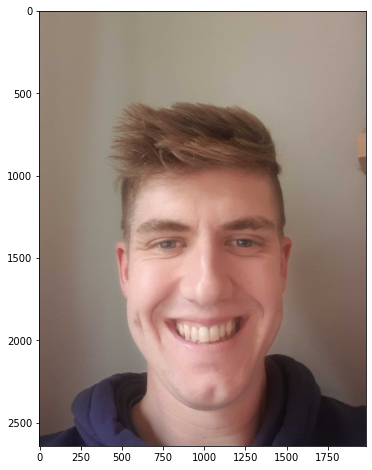

In [65]:
plt.imshow(img_rgb);

## OpenCV face extraction

https://docs.opencv.org/4.x/db/d28/tutorial_cascade_classifier.html

((2640, 1980), 245)

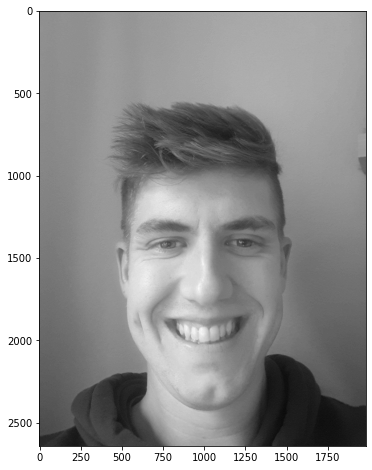

In [66]:
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
# normalizes the brightness and increases the contrast of the image
plt.imshow(img_gray, cmap='gray')
img_gray.shape, img_gray.max()

### Histogram Equalization
* flattens the gray-level histogram 
* all intensities are as equally common as possible

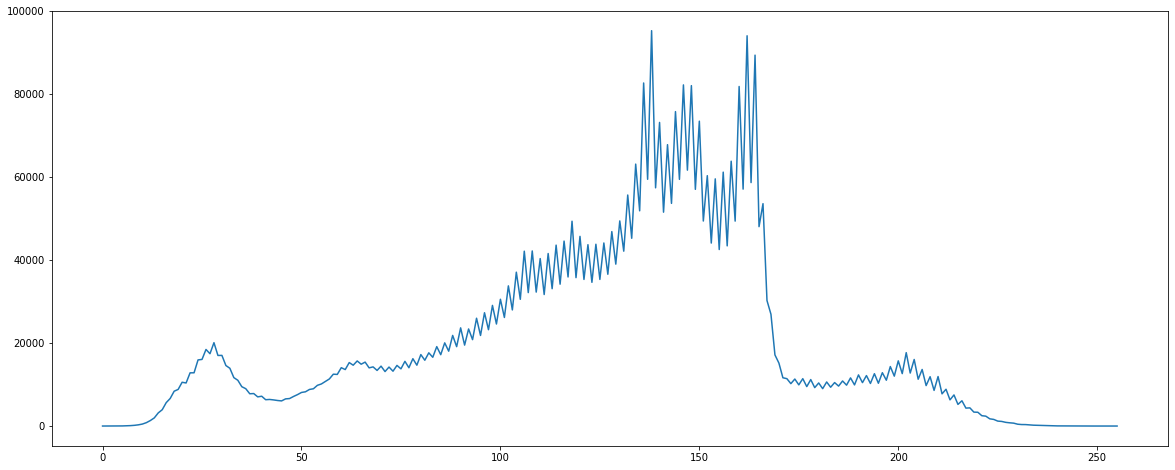

In [67]:
histr = cv.calcHist([img_gray],[0],None,[256],[0,256])
plt.plot(histr);

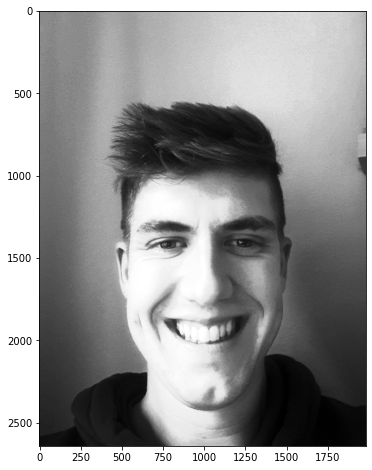

In [68]:
img_gray = cv.equalizeHist(img_gray)
plt.imshow(img_gray, cmap='gray');

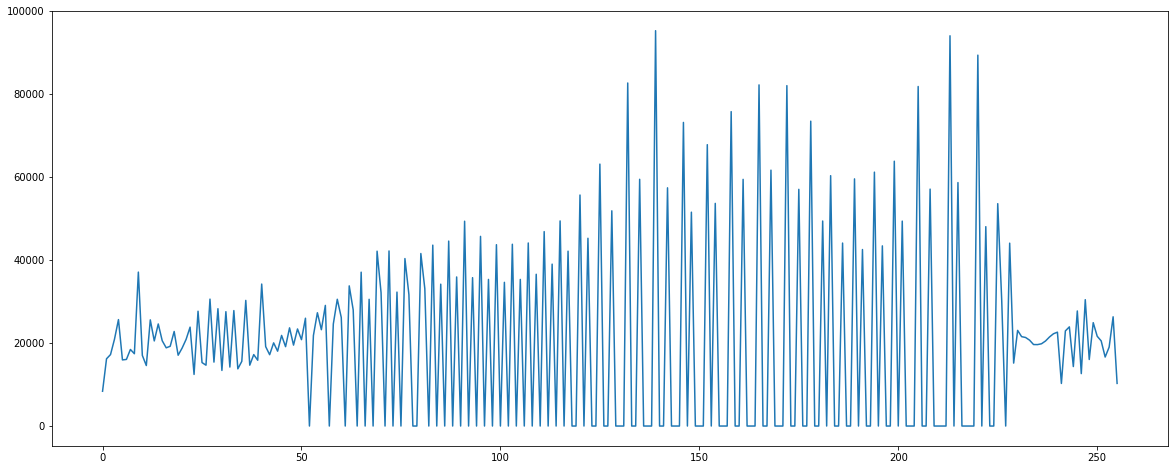

In [69]:
histr = cv.calcHist([img_gray],[0],None,[256],[0,256])
plt.plot(histr);

### Finding faces in the image

In [70]:
img_height, img_width = img_gray.shape
img_height, img_width

(2640, 1980)

In [71]:
min_face_height = round(img_height * .1)
min_face_width = round(img_width * .1)
min_face_height, min_face_width

(264, 198)

In [72]:
faceCascade = cv.CascadeClassifier(cv.data.haarcascades + "haarcascade_frontalface_default.xml")
faces = faceCascade.detectMultiScale(
        img_gray,
        minSize=(min_face_height, min_face_width)
) 
faces

array([[ 358,  906, 1274, 1274]], dtype=int32)

In [73]:
# we assume a single face
largest_index = faces[:, 3].argmax()
face = faces[largest_index]
fx, fy, fw, fh = face
face

array([ 358,  906, 1274, 1274], dtype=int32)

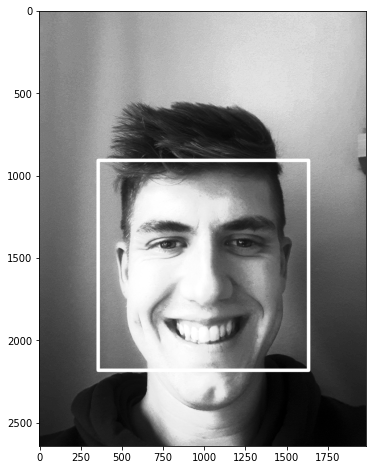

In [74]:
color = (255, 0, 255)
thickness = 20

frame_gray = img_gray.copy()

center = (fx + fw//2, y + fh//2)
# frame = cv.ellipse(frame, center, (w//2, h//2), 0, 0, 360, color, thickness)
pt1 = (fx, fy)
pt2 = (fx + fw, fy + fh)
cv.rectangle(frame_gray, pt1, pt2, color, thickness)
plt.imshow(frame_gray, cmap='gray');    

(1274, 1274)

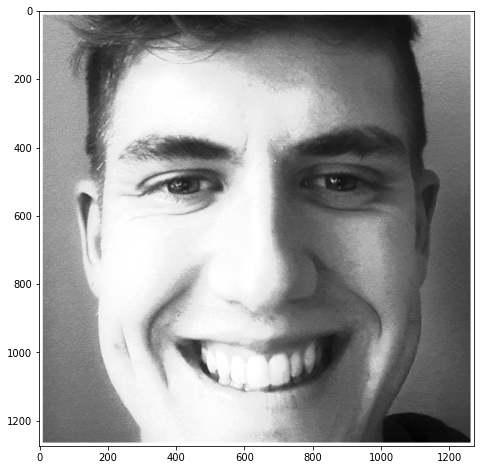

In [75]:
roi = frame_gray[fy:fy+fh,fx:fx+fw]
plt.imshow(roi, cmap='gray');
roi.shape

### Preparation for prediction

In [76]:
roi = cv.resize(roi, (48, 48), 0, 0, cv.INTER_AREA);
# roi = cv.normalize(roi, 0, 1.0, cv.NORM_MINMAX);
roi = roi / 255.0

((48, 48), 0.00784313725490196, 1.0)

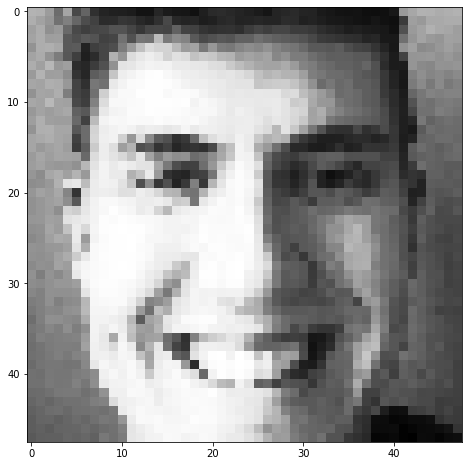

In [77]:
plt.imshow(roi, cmap='gray');
roi.shape, roi.min(), roi.max()

In [78]:
test_img = np.expand_dims(roi, axis=-1)
test_img = np.expand_dims(test_img, axis=0)
test_img.shape

(1, 48, 48, 1)

In [79]:
# you can load a predefined model

!wget -c https://github.com/DJCordhose/ml-resources/raw/main/data/tmp/simple-vgg.h5
!wget -c https://github.com/DJCordhose/ml-resources/raw/main/data/tmp/resent50.h5

--2022-10-29 18:15:33--  https://github.com/DJCordhose/ml-resources/raw/main/data/tmp/simple-vgg.h5
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/DJCordhose/ml-resources/main/data/tmp/simple-vgg.h5 [following]
--2022-10-29 18:15:33--  https://media.githubusercontent.com/media/DJCordhose/ml-resources/main/data/tmp/simple-vgg.h5
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 416 Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

--2022-10-29 18:15:34--  https://github.com/DJCordhose/ml-resources/raw/main/data/tmp/resent50.h5
Resolving github.com (github.com)... 140

In [80]:
import tensorflow as tf
# model = tf.keras.models.load_model('simple-vgg.h5')
# model = tf.keras.models.load_model('resent50.h5')

In [81]:
y_pred_probas = model.predict(test_img)
clazz = y_pred_probas.argmax()
proba = y_pred_probas.max()
filtered_label_names[clazz], proba, y_pred_probas

1/1 [==============================] - 0s 40ms/step


('Happy',
 0.9686428,
 array([[0.00239188, 0.9686428 , 0.00817089, 0.00189756, 0.01889704]],
       dtype=float32))

In [82]:
filtered_label_names

['Angry', 'Happy', 'Sad', 'Surprise', 'Neutral']

## Complete pipeline

In [83]:
def preprocess(path):
  img = cv.imread(path)
  img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
  img_gray = cv.equalizeHist(img_gray)
  # add whatever processing you have here

  face = detect_face(img_gray)
  if face is None:
    return None
  x, y, w, h = face
  frame_gray = img_gray.copy()
  roi = frame_gray[y:y+h,x:x+w]
  roi = cv.resize(roi, (48, 48), 0, 0, cv.INTER_AREA);
  # roi = cv.normalize(roi, 0, 1.0, cv.NORM_MINMAX);
  roi = roi / 255.0
  test_img = np.expand_dims(roi, axis=-1)
  # test_img = np.expand_dims(test_img, axis=0)
  return test_img

def detect_face(img_gray):
  img_height, img_width = img_gray.shape
  min_face_height = round(img_height * .1)
  min_face_width = round(img_width * .1)
  faceCascade = cv.CascadeClassifier(cv.data.haarcascades + "haarcascade_frontalface_default.xml")
  faces = faceCascade.detectMultiScale(
          img_gray,
          minSize=(min_face_height, min_face_width)
  ) 
  if faces is None:
    return None

  # we assume a single face
  largest_index = faces[:, 3].argmax()
  face = faces[largest_index]
  return face

def predict(test_img):
  y_pred_probas = model.predict(test_img)
  clazz = y_pred_probas.argmax()
  proba = y_pred_probas.max()
  return filtered_label_names[clazz], proba, y_pred_probas

(48, 48, 1)

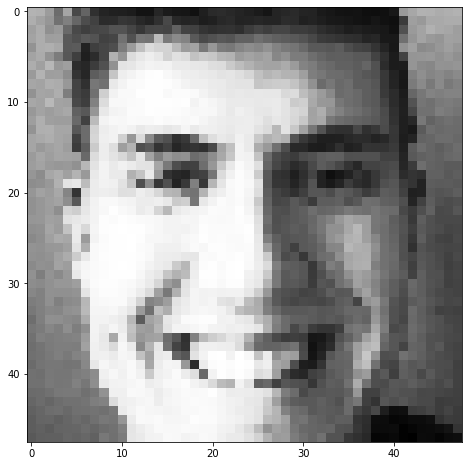

In [84]:
img = preprocess('emotions/happy/tim-happy.jpg')
plt.imshow(img.reshape(48, 48), cmap='gray');
img.shape

In [85]:
predict(np.expand_dims(img, axis=0))

1/1 [==============================] - 0s 18ms/step


('Happy',
 0.9686428,
 array([[0.00239188, 0.9686428 , 0.00817089, 0.00189756, 0.01889704]],
       dtype=float32))

## Evaluation on real world data

In [86]:
!ls -lR emotions

emotions:
total 20
drwxr-xr-x 2 root root 4096 Oct 29 18:15 angry
drwxr-xr-x 2 root root 4096 Oct 29 18:15 happy
drwxr-xr-x 2 root root 4096 Oct 29 18:15 neutral
drwxr-xr-x 2 root root 4096 Oct 29 18:15 sad
drwxr-xr-x 2 root root 4096 Oct 29 18:15 surprise

emotions/angry:
total 2456
-rw-r--r-- 1 root root  173760 Oct 28 09:02 leonie-angry.jpg
-rw-r--r-- 1 root root 2139114 Oct 28 09:06 olli-angry.jpg
-rw-r--r-- 1 root root  194744 Oct 28 08:53 tim-angry.jpg

emotions/happy:
total 2244
-rw-r--r-- 1 root root  190881 Oct 28 09:03 leonie-happy.jpg
-rw-r--r-- 1 root root 1913455 Oct 28 09:06 olli-happy.jpg
-rw-r--r-- 1 root root  186775 Oct 28 08:53 tim-happy.jpg

emotions/neutral:
total 2144
-rw-r--r-- 1 root root  210110 Oct 28 09:03 leonie-neutral.jpg
-rw-r--r-- 1 root root 1808204 Oct 28 09:06 olli-neutral.jpg
-rw-r--r-- 1 root root  169542 Oct 28 08:52 tim-neutral.jpg

emotions/sad:
total 2576
-rw-r--r-- 1 root root  216864 Oct 28 09:02 leonie-sad.jpg
-rw-r--r-- 1 root root 2214639 O

In [87]:
%%time 

import os
data_dir = 'emotions'
type = ".jpg"

# Get all subdirectories of data_dir. Each represents a label.
directories = [d for d in os.listdir(data_dir) 
                if os.path.isdir(os.path.join(data_dir, d))]
# Loop through the label directories and collect the data in
# two lists, labels and images.
labels = []
images = []
for d in directories:
    label_dir = os.path.join(data_dir, d)
    file_names = [os.path.join(label_dir, f) for f in os.listdir(label_dir) if f.endswith(type)]
    # For each label, load it's images and add them to the images list.
    # And add the label number (i.e. directory name) to the labels list.
    for f in file_names:
      img = preprocess(f)
      images.append(img)
      label = filtered_label_names.index(d.title())
      labels.append(label)

images, labels = np.array(images), np.array(labels)

CPU times: user 3.46 s, sys: 194 ms, total: 3.66 s
Wall time: 2.19 s


In [88]:
images.shape, labels

((15, 48, 48, 1), array([4, 4, 4, 1, 1, 1, 3, 3, 3, 0, 0, 0, 2, 2, 2]))

In [89]:
X_real_world = images
y_real_world = labels

### Current Model

In [90]:
model.name

'custom_vgg'

In [91]:
_, real_world_accuracy = model.evaluate(X_real_world, y_real_world, verbose=0)
real_world_accuracy

0.6000000238418579

1/1 [==============================] - 0s 18ms/step


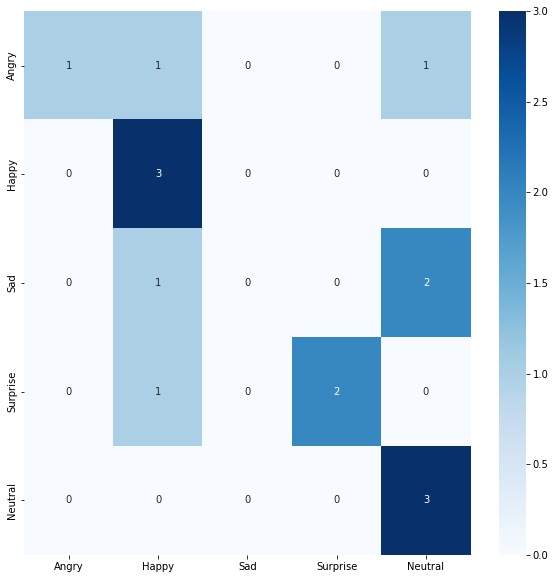

In [92]:
plot_cm(model, X_real_world, y_real_world, label_names=filtered_label_names);

### Custom VGG

In [93]:
# you can load a predefined model

!curl -O https://media.githubusercontent.com/media/DJCordhose/ml-resources/main/data/tmp/resent50.h5
!curl -O https://media.githubusercontent.com/media/DJCordhose/ml-resources/main/data/tmp/simple-vgg.h5

--2022-10-29 18:15:43--  https://github.com/DJCordhose/ml-resources/raw/main/data/tmp/simple-vgg.h5
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/DJCordhose/ml-resources/main/data/tmp/simple-vgg.h5 [following]
--2022-10-29 18:15:43--  https://media.githubusercontent.com/media/DJCordhose/ml-resources/main/data/tmp/simple-vgg.h5
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 416 Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

--2022-10-29 18:15:43--  https://github.com/DJCordhose/ml-resources/raw/main/data/tmp/resent50.h5
Resolving github.com (github.com)... 140

In [94]:
import tensorflow as tf
model = tf.keras.models.load_model('simple-vgg.h5')
# model = tf.keras.models.load_model('resent50.h5')

In [95]:
_, real_world_accuracy = model.evaluate(X_real_world, y_real_world, verbose=0)
real_world_accuracy

0.6000000238418579

1/1 [==============================] - 0s 131ms/step


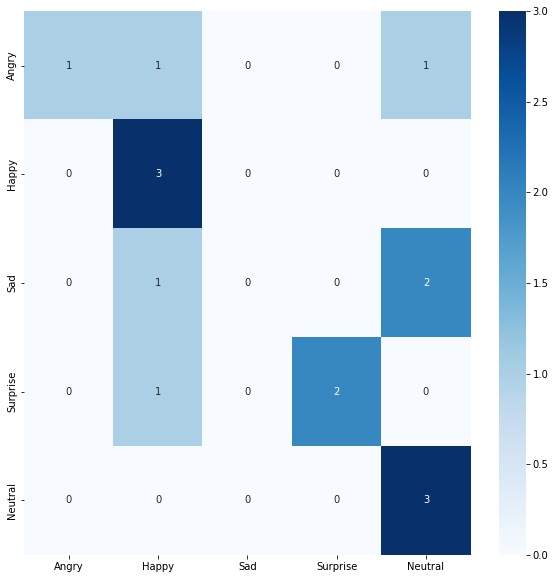

In [96]:
plot_cm(model, X_real_world, y_real_world, label_names=filtered_label_names);

### Resnet 50

In [97]:
import tensorflow as tf
# model = tf.keras.models.load_model('simple-vgg.h5')
model = tf.keras.models.load_model('resent50.h5')

In [98]:
model.name

'resnet50'

In [99]:
_, real_world_accuracy = model.evaluate(X_real_world, y_real_world, verbose=0)
real_world_accuracy

0.6666666865348816

1/1 [==============================] - 1s 860ms/step


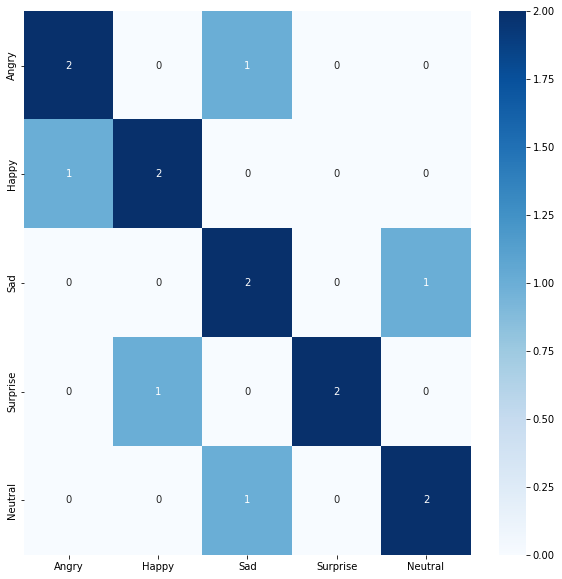

In [100]:
plot_cm(model, X_real_world, y_real_world, label_names=filtered_label_names);

## Looking at subclasses

In [101]:
def plot_gallery(model, X, y, label_names, size=15):
    figure = plt.figure(figsize=(40, 20))

    y_pred_raw = model.predict(X, verbose=0)
    certainty = y_pred_raw.max(axis=1)
    y_pred = y_pred_raw.argmax(axis=1)
    population = X.shape[0]

    if size and size < population:
        samples = np.random.choice(population, size=size, replace=False)
    else:
        # just all
        samples = np.arange(0, population)

    for idx, i in enumerate(samples):
        ax = plt.subplot(3, 5, idx + 1)
        image = X[i]
        plt.imshow(image.reshape(48, 48), cmap='gray')
        y_true = y[i]
        y_pred = model.predict(tf.expand_dims(image, 0), verbose=0).argmax(axis=1)[0]
        plt.title("{} (was {}): {} ({:3d}%)".format(label_names[y_pred],
                                                  label_names[y_true],
                                                  i,
                                                  int(certainty[i] * 100)),
                  color=("green" if y_pred == y_true else "red"))
        plt.axis("off")
    return certainty.max(), certainty.min(), certainty.mean()

In [102]:
y_real_world_pred_raw = model.predict(X_real_world, verbose=0)
y_real_world_pred = y_real_world_pred_raw.argmax(axis=1)
y_real_world_pred

array([4, 4, 2, 1, 1, 0, 1, 3, 3, 2, 0, 0, 4, 2, 2])

### All

(0.9999788, 0.6546878, 0.88930863)

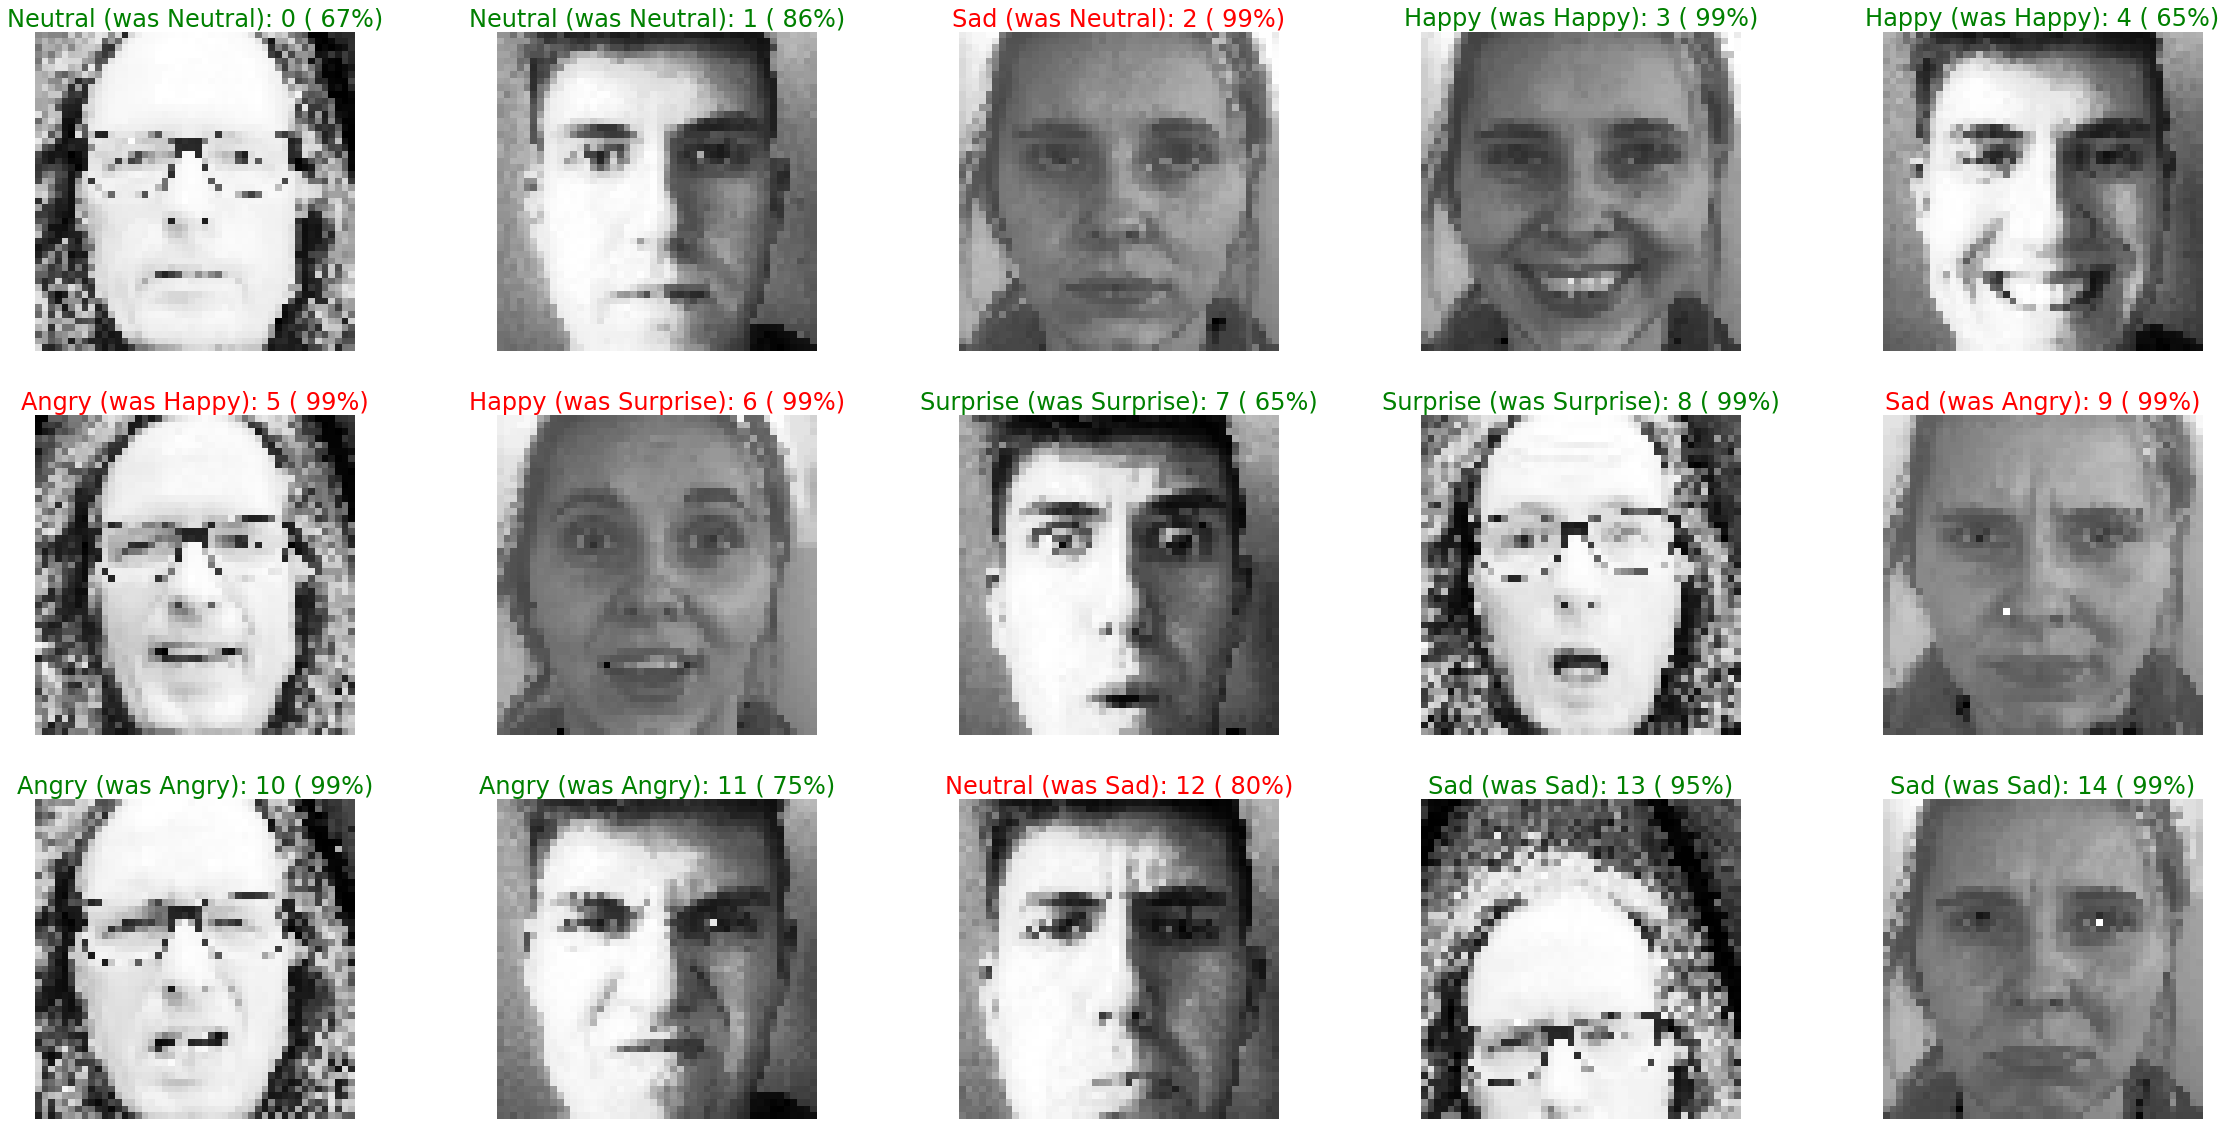

In [103]:
plot_gallery(model, X_real_world, y_real_world, filtered_label_names)

### Wrong

In [104]:
wrong_indices = np.where(y_real_world_pred != y_real_world)[0]
wrong_indices

array([ 2,  5,  6,  9, 12])

(0.9990029, 0.8014818, 0.95741063)

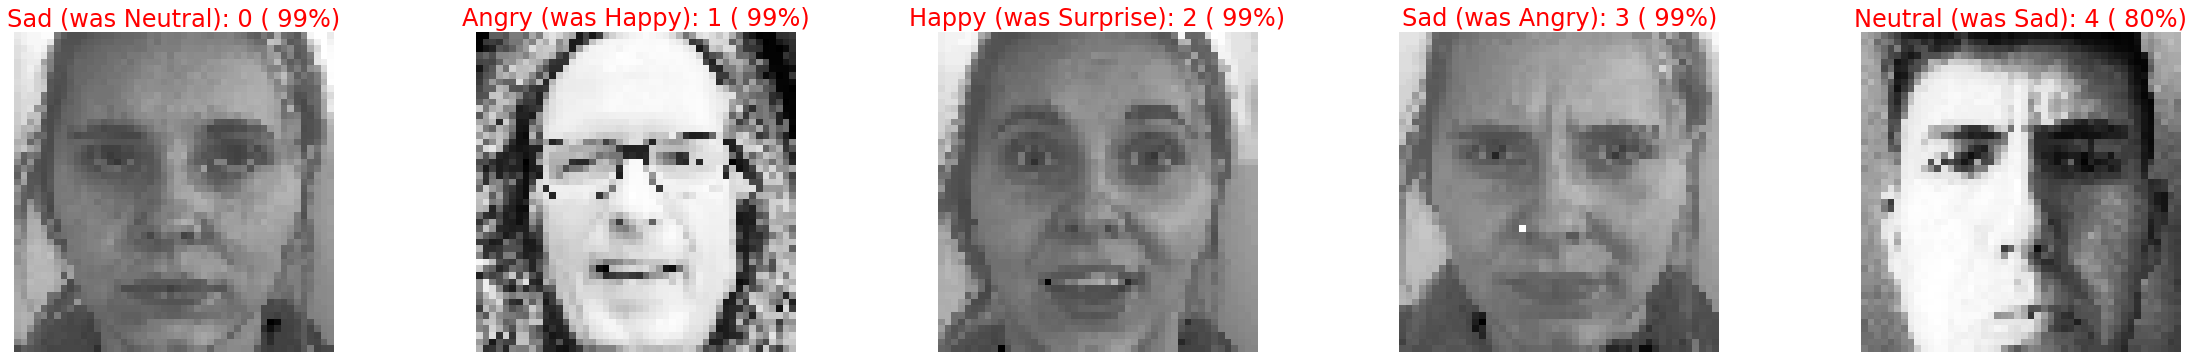

In [105]:
plot_gallery(model, X_real_world[wrong_indices], y_real_world[wrong_indices], filtered_label_names)

### Low Certainty

In [106]:
certainty = y_real_world_pred_raw.max(axis=1)
certainty

array([0.6735639 , 0.867043  , 0.99834645, 0.9999788 , 0.6546878 ,
       0.9981109 , 0.9901112 , 0.65991133, 0.99770904, 0.9990029 ,
       0.99588156, 0.75207806, 0.801486  , 0.95191413, 0.9998047 ],
      dtype=float32)

In [107]:
# threshold = 0.6
threshold = 0.9

In [108]:
low_certainty_indices = np.where(certainty < threshold)[0]
low_certainty_indices

array([ 0,  1,  4,  7, 11, 12])

(0.86706376, 0.6546698, 0.7348192)

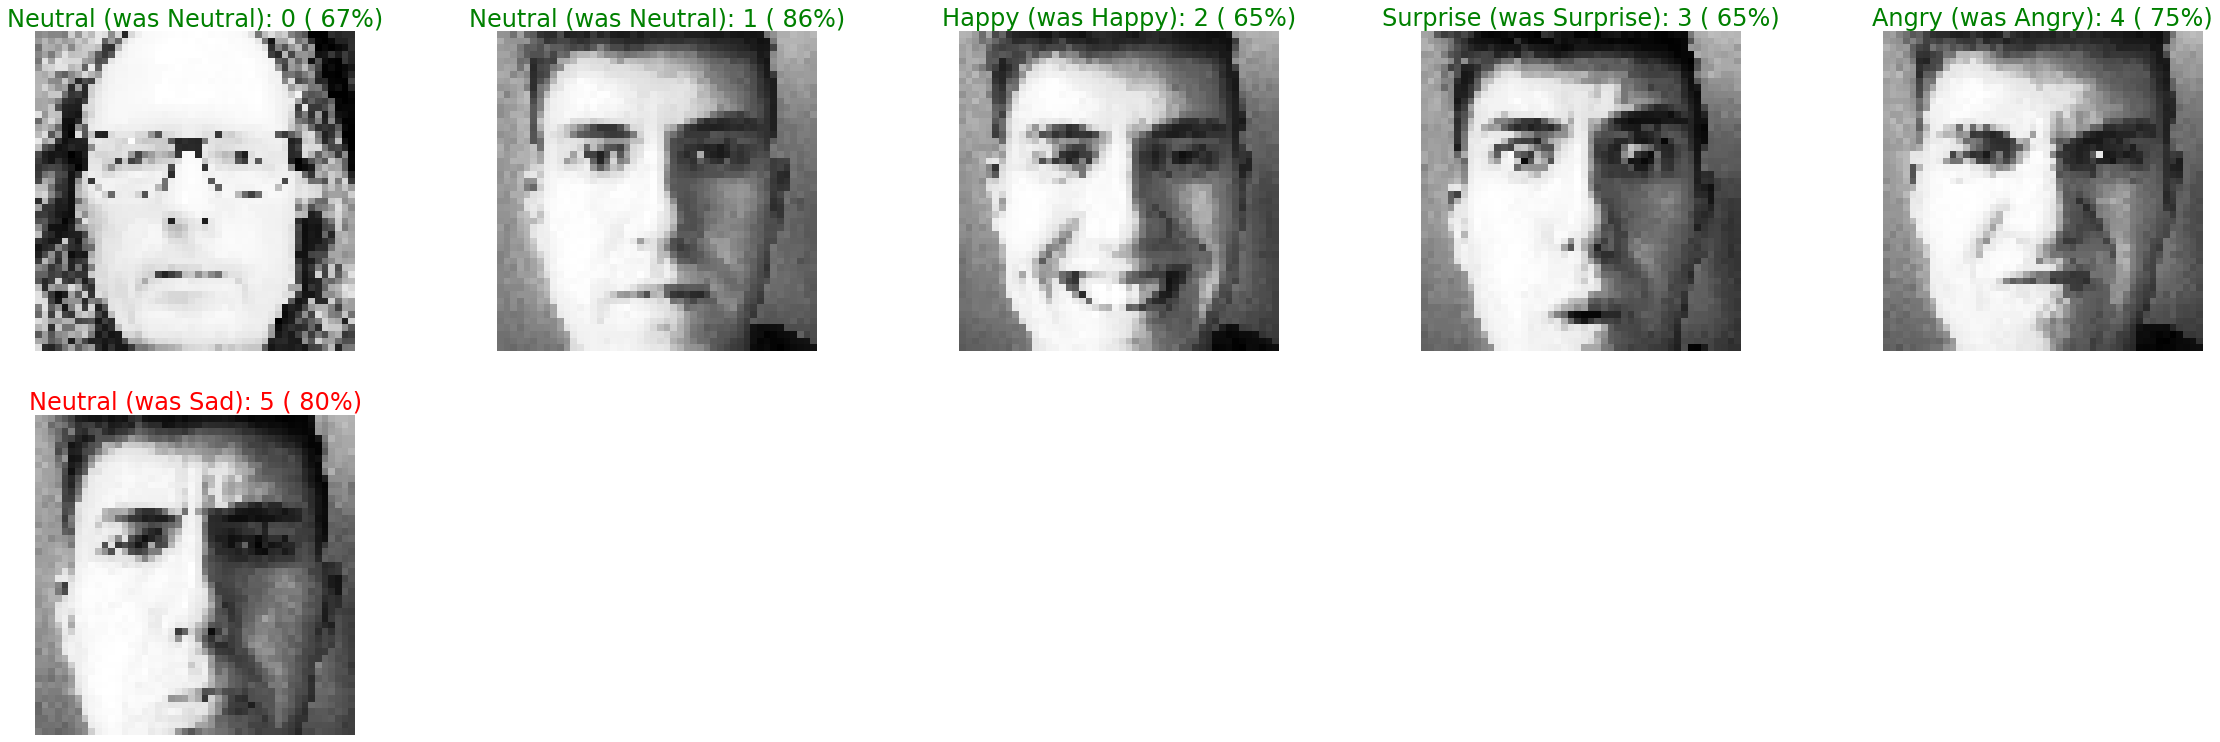

In [109]:
plot_gallery(model, X_real_world[low_certainty_indices], y_real_world[low_certainty_indices], filtered_label_names)

### High Certainty

In [110]:
# threshold = 0.80
threshold = 0.99

In [111]:
low_certainty_indices = np.where(certainty > threshold)[0]
low_certainty_indices

array([ 2,  3,  5,  6,  8,  9, 10, 14])

(0.9999788, 0.9901113, 0.9973682)

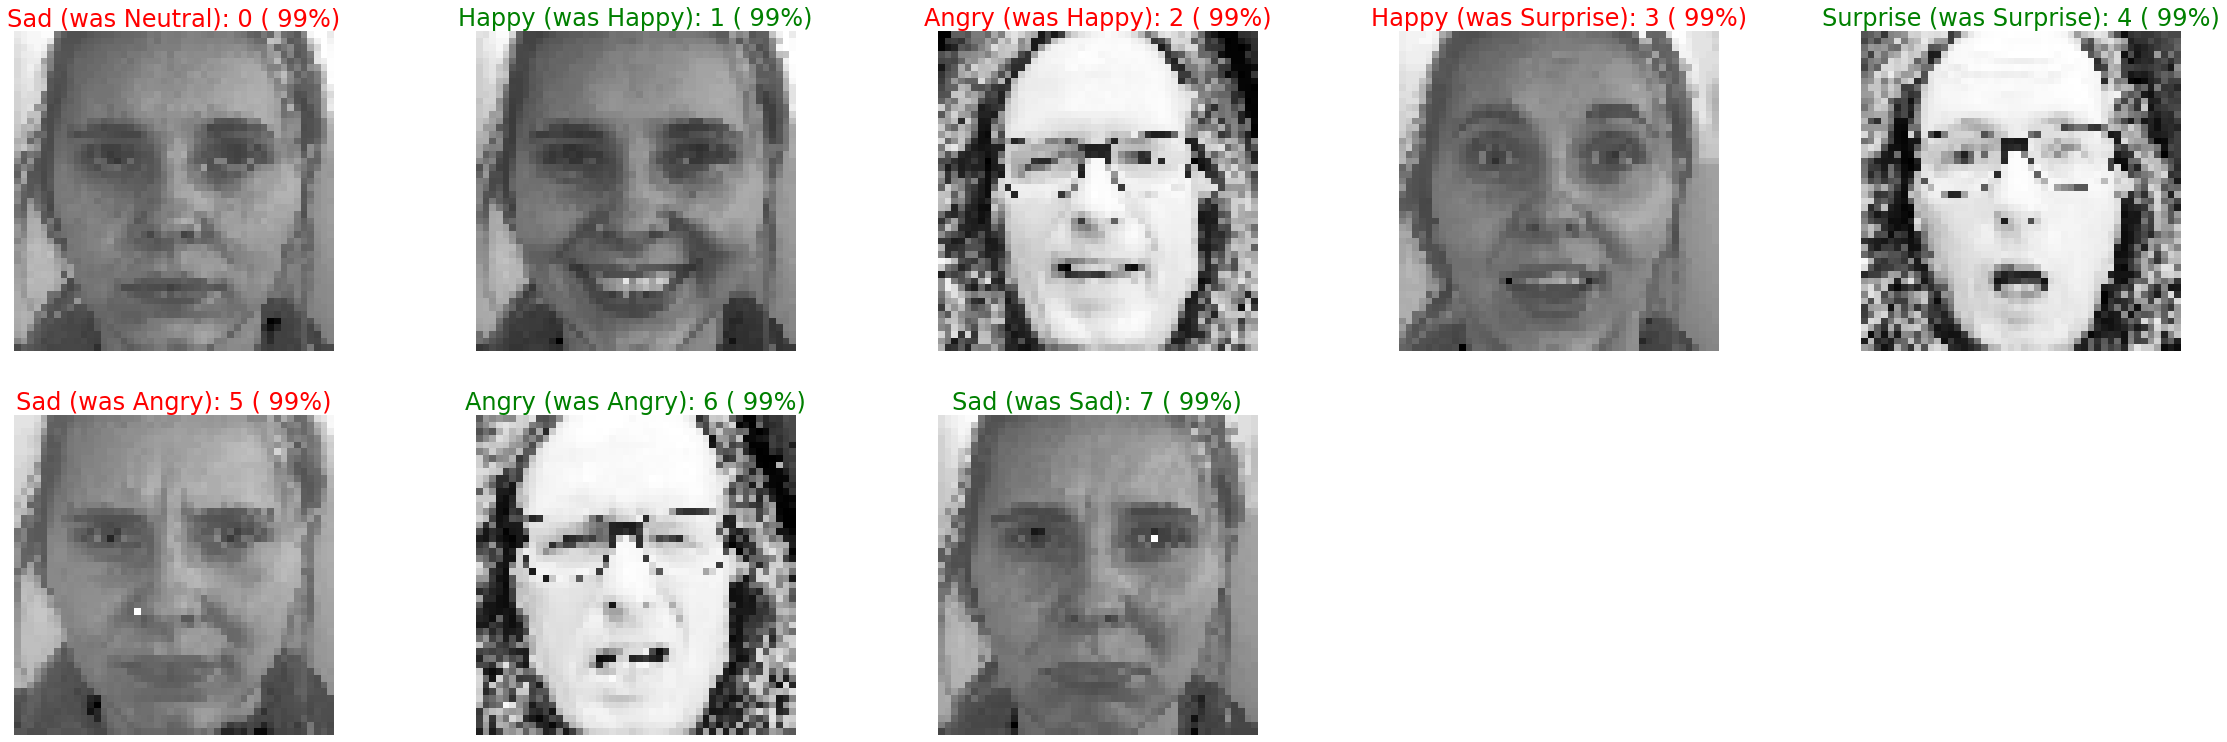

In [112]:
plot_gallery(model, X_real_world[low_certainty_indices], y_real_world[low_certainty_indices], filtered_label_names)

## Optional Step: fine tune model with on world data

* add one (few) iterations on real world data
* most likely resnet works better for that as it has more capacity and no means of preventing overfitting on our small data set
* obvious risk: we overfit on the real world data and don't even notice
* mediocre solution: even split real world data into train and test

_does not really make sense unless we have at least a few hundred samples here_

In [123]:
# you can load a predefined model

!curl -O https://media.githubusercontent.com/media/DJCordhose/ml-resources/main/data/tmp/resent50.h5
!curl -O https://media.githubusercontent.com/media/DJCordhose/ml-resources/main/data/tmp/simple-vgg.h5

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  270M  100  270M    0     0   221M      0  0:00:01  0:00:01 --:--:--  221M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4643k  100 4643k    0     0  31.9M      0 --:--:-- --:--:-- --:--:-- 31.9M


In [124]:
import tensorflow as tf
# model = tf.keras.models.load_model('simple-vgg.h5')
model = tf.keras.models.load_model('resent50.h5')

In [125]:
# before training
_, real_world_accuracy = model.evaluate(X_real_world, y_real_world, verbose=0)
real_world_accuracy

0.6666666865348816

In [126]:
# due to a lack of good validation data we check on the original data set
_, accuracy = model.evaluate(X, y, verbose=0)
accuracy

0.8915252089500427

In [127]:
# our data set is just too small to do the split in a reasonable way
# so we train on full set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_real_world, y_real_world, test_size=0.3, random_state=21, stratify=y_real_world)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((10, 48, 48, 1), (5, 48, 48, 1), (10,), (5,))

In [128]:
%%time

from lrcurve import KerasLearningCurve

BATCH_SIZE = 50
EPOCHS = 10

lr = 0.01 # default
# lr = 0.001 # low

optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
# optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
model.compile(loss='sparse_categorical_crossentropy',
             optimizer=optimizer,
             metrics=['accuracy'])

history = model.fit(X_real_world, y_real_world, 
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    shuffle=True,
                    callbacks=[KerasLearningCurve()],
                    verbose=0
                    )

CPU times: user 4.72 s, sys: 56.7 ms, total: 4.77 s
Wall time: 5.68 s


In [129]:
# after training
_, real_world_accuracy = model.evaluate(X_real_world, y_real_world, batch_size=BATCH_SIZE, verbose=0)
real_world_accuracy

0.800000011920929

In [130]:
# due to a lack of good validation data we check on the original data set
_, accuracy = model.evaluate(X, y, verbose=0)
accuracy

0.7647175788879395

1/1 [==============================] - 1s 944ms/step


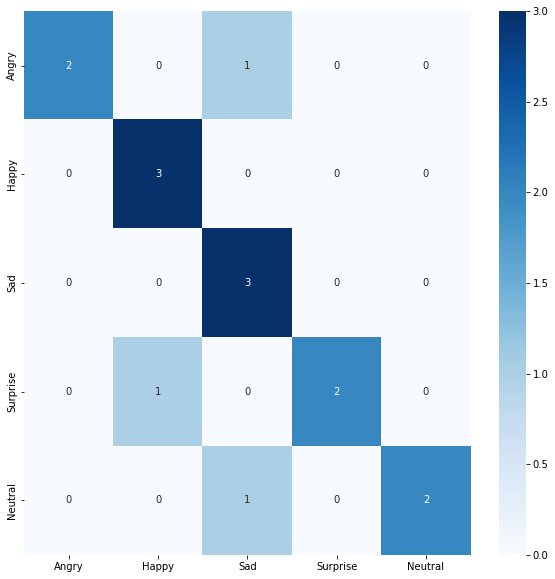

In [131]:
plot_cm(model, X_real_world, y_real_world, label_names=filtered_label_names);